# Clustering: K-Means In-Depth

||continuous|categorical|
|---|---|---|
|supervised|regression|classification|
|**unsupervised**|dimension reduction|**clustering**|

Here we'll explore **K Means Clustering**, which is an unsupervised clustering technique.

We'll start with our standard set of initial imports

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

import warnings
warnings.filterwarnings('ignore')

## Introducing K-Means

K Means is an algorithm for **unsupervised clustering**: 
- that is, finding clusters in data based on the data attributes alone (not the labels).

K Means is a relatively easy-to-understand algorithm.  
- It searches for cluster centers which are the mean of the points within them, such that every point is closest to the cluster center it is assigned to.

Let's look at how KMeans operates on the simple clusters we looked at previously. To emphasize that this is unsupervised, we'll not plot the colors of the clusters:

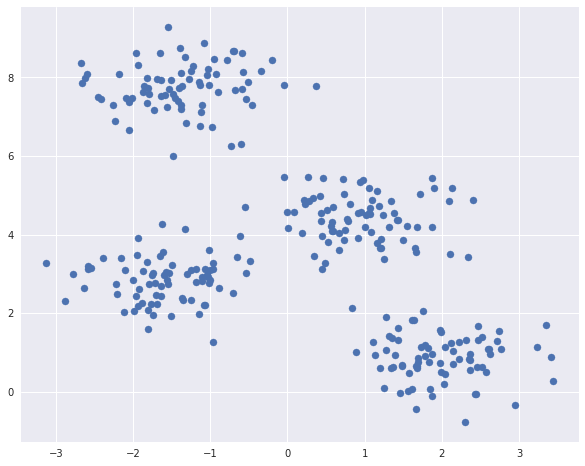

In [2]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=0.60)
plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1], s=50);

By eye, it is relatively easy to pick out the four clusters. 

- If you were to perform an exhaustive search for the different segmentations of the data, however, the search space would be exponential in the number of points. 

- Fortunately, there is a well-known *Expectation Maximization (EM)* procedure which scikit-learn implements, so that KMeans can be solved relatively quickly.

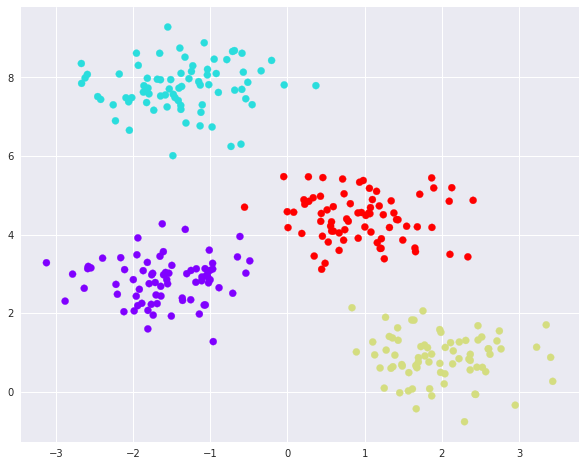

In [3]:
from sklearn.cluster import KMeans
est = KMeans(4)  # 4 clusters
est.fit(X)
y_kmeans = est.predict(X)
plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='rainbow');

The algorithm identifies the four clusters of points in a manner very similar to what we would do by eye!

## The K-Means Algorithm: Expectation Maximization

K-Means is an example of an algorithm which uses an *Expectation-Maximization* approach to arrive at the solution.

***Expectation-Maximization*** is a two-step approach which works as follows:

1. Guess some cluster centers
2. Repeat until converged
    1. Assign points to the nearest cluster center
    2. Set the cluster centers to the mean 
   
Let's quickly visualize this process:

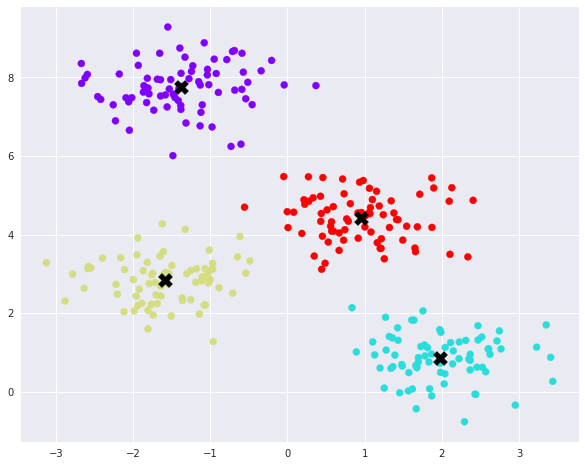

In [24]:
plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='rainbow');
centroids = est.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='X', s=200, cmap='rainbow',
            color='black')

This algorithm will (often) converge to the optimal cluster centers.

### KMeans Caveats

- The convergence of this algorithm is ***not guaranteed***; 
    - For that reason, scikit-learn by default uses a large number of random initializations and finds the best results.

- Also, the number of clusters must be set beforehand.

... there are other clustering algorithms for which this requirement may be lifted.

## Application of KMeans to Digits

For a closer-to-real-world example, let's again take a look at the digits data. Here we'll use KMeans to automatically cluster the data in 64 dimensions, and then look at the cluster centers to see what the algorithm has found.

In [25]:
from sklearn.datasets import load_digits
digits = load_digits()

In [26]:
est = KMeans(n_clusters=10)
clusters = est.fit_predict(digits.data)
est.cluster_centers_.shape

(10, 64)

We see ten clusters in 64 dimensions. Let's visualize each of these cluster centers to see what they represent:

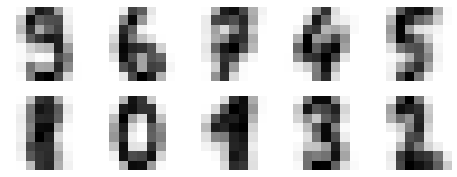

In [27]:
fig = plt.figure(figsize=(8, 3))
for i in range(10):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.imshow(est.cluster_centers_[i].reshape((8, 8)), cmap=plt.cm.binary)

We see that *even without the labels*, KMeans is able to find clusters whose means are recognizable digits (with apologies to the number 8)!

The cluster labels are permuted; let's fix this:

In [28]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

For good measure, let's use our PCA visualization and look at the true cluster labels and K-means cluster labels:

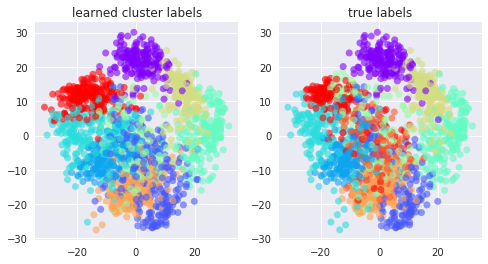

In [30]:
from sklearn.decomposition import PCA

X = PCA(2).fit_transform(digits.data)

kwargs = dict(cmap = plt.cm.get_cmap('rainbow', 10),
              edgecolor='none', alpha=0.6)
plt.figure(figsize=(10,8))
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].scatter(X[:, 0], X[:, 1], c=labels, **kwargs)
ax[0].set_title('learned cluster labels')

ax[1].scatter(X[:, 0], X[:, 1], c=digits.target, **kwargs)
ax[1].set_title('true labels');

Just for kicks, let's see how accurate our K-Means classifier is **with no label information:**

In [31]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.77963272120200333

77% – not bad! Let's check-out the confusion matrix for this:

[[177   0   0   0   1   0   0   0   0   0]
 [  0 154  25   0   0   1   2   0   0   0]
 [  1   9 145  19   0   0   0   2   0   1]
 [  0   3   1 136   0   2   0   6   0  35]
 [  0   5   0   0 166   0   0  10   0   0]
 [  0   0   0   1   2 138   2   0   0  39]
 [  1   3   0   0   0   0 177   0   0   0]
 [  0   4   0   0   0   5   0 170   0   0]
 [  0  97   3  61   0   6   1   3   0   3]
 [  0  20   0   8   0   6   0   8   0 138]]


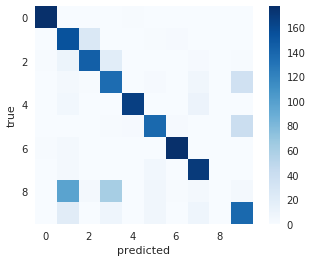

In [33]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(digits.target, labels))

plt.imshow(confusion_matrix(digits.target, labels),
           cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted');

Again, this is an 77% classification accuracy for an **entirely unsupervised estimator** which knew nothing about the labels.

## Example: KMeans for Color Compression

One interesting application of clustering is in color image compression. 
- For example, imagine you have an image with millions of colors. 
    - In most images, a large number of the colors will be unused, and conversely a large number of pixels will have similar or identical colors.

Scikit-learn has a number of images that you can play with, accessed through the datasets module. For example:

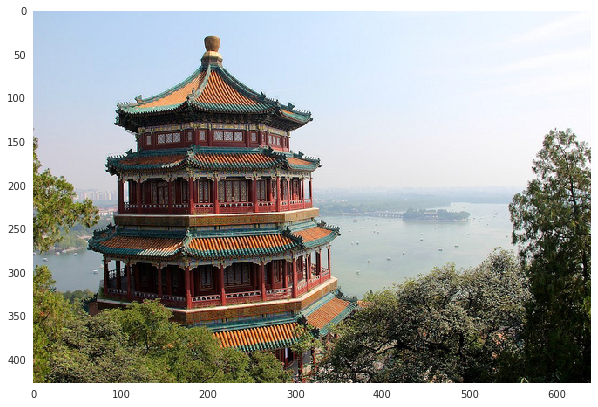

In [46]:
from sklearn.datasets import load_sample_image
from IPython.display import display 
from PIL import Image
china = load_sample_image("china.jpg")
plt.figure(figsize=(10,8))
plt.imshow(china)
plt.grid(False);

The image itself is stored in a 3-dimensional array, of size ``(height, width, RGB)``:

In [47]:
china.shape

(427, 640, 3)

We can envision this image as a cloud of points in a 3-dimensional color space. We'll rescale the colors so they lie between 0 and 1, then reshape the array to be a typical scikit-learn input:

In [48]:
X = (china / 255.0).reshape(-1, 3)
print(X.shape)

(273280, 3)


We now have 273,280 points in 3 dimensions.

Our task is to use KMeans to compress the $256^3$ colors into a smaller number (say, 64 colors). Basically, we want to find $N_{color}$ clusters in the data, and create a new image where the true input color is replaced by the color of the closest cluster.

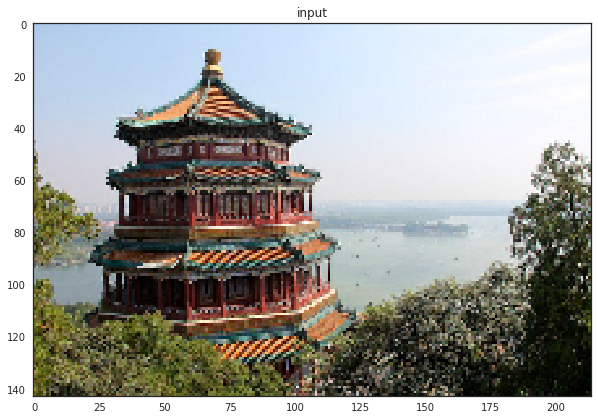

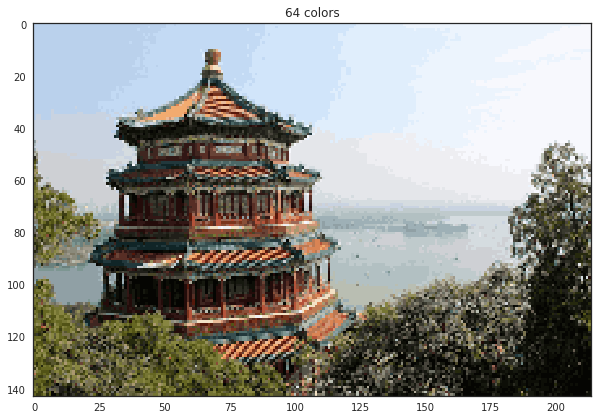

In [49]:
# reduce the size of the image for speed
image = china[::3, ::3]
n_colors = 64

X = (image / 255.0).reshape(-1, 3)
    
model = KMeans(n_colors)
labels = model.fit_predict(X)
colors = model.cluster_centers_
new_image = colors[labels].reshape(image.shape)
new_image = (255 * new_image).astype(np.uint8)

# create and plot the new image
with sns.axes_style('white'):
    plt.figure(figsize=(10,8))
    plt.imshow(image)
    plt.title('input')

    plt.figure(figsize=(10,8))
    plt.imshow(new_image)
    plt.title('{0} colors'.format(n_colors))

Compare the input and output image: we've reduced the $256^3$ colors to just 64.

<small><i>Reference [GitHub](https://github.com/jakevdp/sklearn_pycon2015/).</i></small>